<h1 style="text-align:center;">Лабораторная работа №2</h1>

<h3 style="text-align:center;">Осипов Алексей Б01-204</h3>

**Цель**: взять модель суточных колебаний концентрации озона в атмосфере и провести для неё численное решение, исследовать зависимость решения от шага интегрирования


Система ОДУ описывается уравнениями:

$$
\dot{y}_1 = -k_1 y_1 y_2 - k_2 y_1 y_3 + 2k_3(t) y_2 + k_4(t) y_3,
$$

$$
\dot{y}_2 = 2k_2 y_1 y_3 - k_3(t) y_2,
$$

$$
\dot{y}_3 = k_1 y_1 y_2 - k_2 y_1 y_3 - k_4(t) y_3.
$$


Начальные условия:

$$
y_1(0) = 10^6 \ \text{(см}^{-3}), \quad y_2(0) = 3.7 \cdot 10^{16} \ \text{(см}^{-3}), \quad y_3(0) = 10^{12} \ \text{(см}^{-3}),
$$

значения постоянных скоростей химических реакций:

$$
k_1 = 1.63 \cdot 10^{-16}, \quad k_2 = 4.66 \cdot 10^{-16}.
$$

Две другие химические реакции зависят от локальной освещенности участка земной поверхности и приближаются следующим выражением:

$$
k_i(t) =
\begin{cases}
\exp(-c_i / \sin \omega t), & \sin \omega t > 0, \\
0, & \sin \omega t < 0,
\end{cases}
$$

где $\omega = \pi / 43200 \ \text{с}^{-1}, \quad c_3 = 22.62, \quad c_4 = 7.601$.

Значения констант скоростей обращаются в нуль ночью, резко возрастают на рассвете, достигают максимума в полдень и падают до нуля на закате.

Конечное время интегрирования: $T_k = 172800$ с (двое суток).

> Данная система является жёсткой ночью и умеренно жёсткой в светлое время суток.


Для решения данной системы будем использовать следующие методы:

0. Явный метод Рунге-Кутты 4-го порядка
1. Неявный метод Рунге-Кутты 3-го порядка
2. Неявный метод Адамса 3-го порядка
3. Метод Розенброка-Ваннера 2 и 3 порядка

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

<h3 style="text-align:center;">Явный метод Рунге - Кутты</h3>

In [7]:
# Константы из задачи
k1 = 1.63e-16
k2 = 4.66e-16
c3 = 22.62
c4 = 7.601
omega = np.pi / 43200  # рад/с
T = 172800  # 2 суток (в секундах)

# Начальные условия
Y0 = np.array([1e6, 3.7e16, 1e12])  # y1, y2, y3
t_end = T

# k3(t), k4(t)
def k3(t):
    return np.exp(-c3 / np.sin(omega * t)) if np.sin(omega * t) > 1e-4 else 0

def k4(t):
    return np.exp(-c4 / np.sin(omega * t)) if np.sin(omega * t) > 1e-4 else 0

# Правая часть системы
def f(t, Y):
    y1, y2, y3 = Y
    dy1 = -k1 * y1 * y2 - k2 * y1 * y3 + 2 * k3(t) * y2 + k4(t) * y3
    dy2 = 2 * k2 * y1 * y3 - k3(t) * y2
    dy3 = k1 * y1 * y2 - k2 * y1 * y3 - k4(t) * y3
    return np.array([dy1, dy2, dy3])


In [4]:
# RK4 шаг
def rk4_step(t, Y, h):
    k1_ = f(t, Y)
    k2_ = f(t + h/2, Y + h/2 * k1_)
    k3_ = f(t + h/2, Y + h/2 * k2_)
    k4_ = f(t + h, Y + h * k3_)
    return Y + h/6 * (k1_ + 2*k2_ + 2*k3_ + k4_)

# Решатель
def solve_runge_kutta(method, Y0, h, t_end):
    t = 0
    ts = [t]
    Ys = [Y0.copy()]
    Y = Y0.copy()
    while t < t_end:
        Y = method(t, Y, h)
        t += h
        ts.append(t)
        Ys.append(Y.copy())
    return np.array(ts), np.array(Ys)


[0.000000e+00 1.000000e-01 2.000000e-01 ... 1.727998e+05 1.727999e+05
 1.728000e+05]


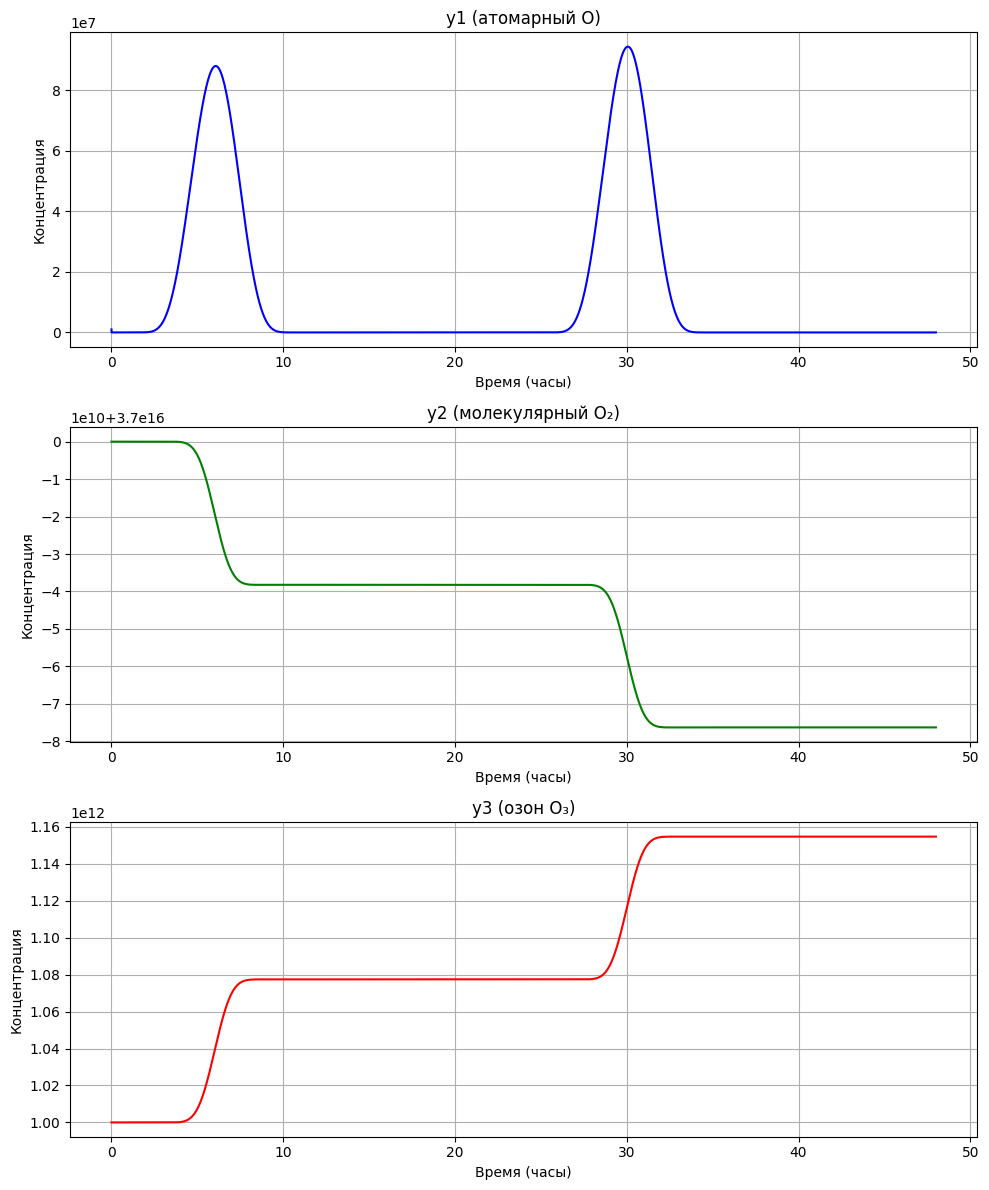

In [ ]:
h = 0.01
ts, Ys = solve_runge_kutta(rk4_step, Y0, h, t_end)

print(ts)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(ts / 3600, Ys[:, 0], color='blue')
axes[0].set_title('y1 (атомарный O)')
axes[0].set_xlabel('Время (часы)')
axes[0].set_ylabel('Концентрация')
axes[0].grid()

axes[1].plot(ts / 3600, Ys[:, 1], color='green')
axes[1].set_title('y2 (молекулярный O₂)')
axes[1].set_xlabel('Время (часы)')
axes[1].set_ylabel('Концентрация')
axes[1].grid()

axes[2].plot(ts / 3600, Ys[:, 2], color='red')
axes[2].set_title('y3 (озон O₃)')
axes[2].set_xlabel('Время (часы)')
axes[2].set_ylabel('Концентрация')
axes[2].grid()

plt.tight_layout()
plt.show()

Как видно, явный метод Рунге - Кутты 4-го порядка хорошо справился даже с жёсткой системой

<h3 style="text-align:center;">Неявный метод Рунге - Кутты</h3>

Таблица Бутчера для неявного метода Рунге–Кутты 3 порядка:
$$ \begin{array}{c|ccccc} 
\frac{1}{4} & \frac{1}{4} & 0 & 0 & 0 & 0 \\ 
\frac{3}{4} & \frac{1}{2} & \frac{1}{4} & 0 & 0 & 0 \\ 
\frac{11}{20} & \frac{17}{50} & -\frac{1}{25} & \frac{1}{4} & 0 & 0 \\ 
\frac{1}{2} & \frac{371}{1360} & -\frac{137}{2720} & \frac{15}{544} & \frac{1}{4} & 0\\ 
1 & \frac{25}{24} & -\frac{49}{48} & \frac{125}{16} & -\frac{85}{12} & \frac{1}{4} \\ 
\hline & \frac{25}{24} & -\frac{49}{48} & \frac{125}{16} & -\frac{85}{12} & \frac{1}{4} 
\end{array} $$

По мере использования неявных методов Рунге - Кутты необходимо решать СНУ, для этого будем использовать метод Ньютона, а также метод Гаусса для промежуточных вычислений, эти функции возьмём из лаб прошлого семестра

C:\Users\osale\AppData\Local\Temp\ipykernel_18960\76959490.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Yi = Y + h * np.sum(A_rk[i, j] * K[j] for j in range(s))
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\76959490.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = (f[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\292704564.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dy1 = -k1 * y1 * y2 - k2 * y1 * y3 + 2 * k3(t) * y2 + k4(t) * y3
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\292704564.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  dy1 = -k1 * y1 * y2 - k2 * y1 * y

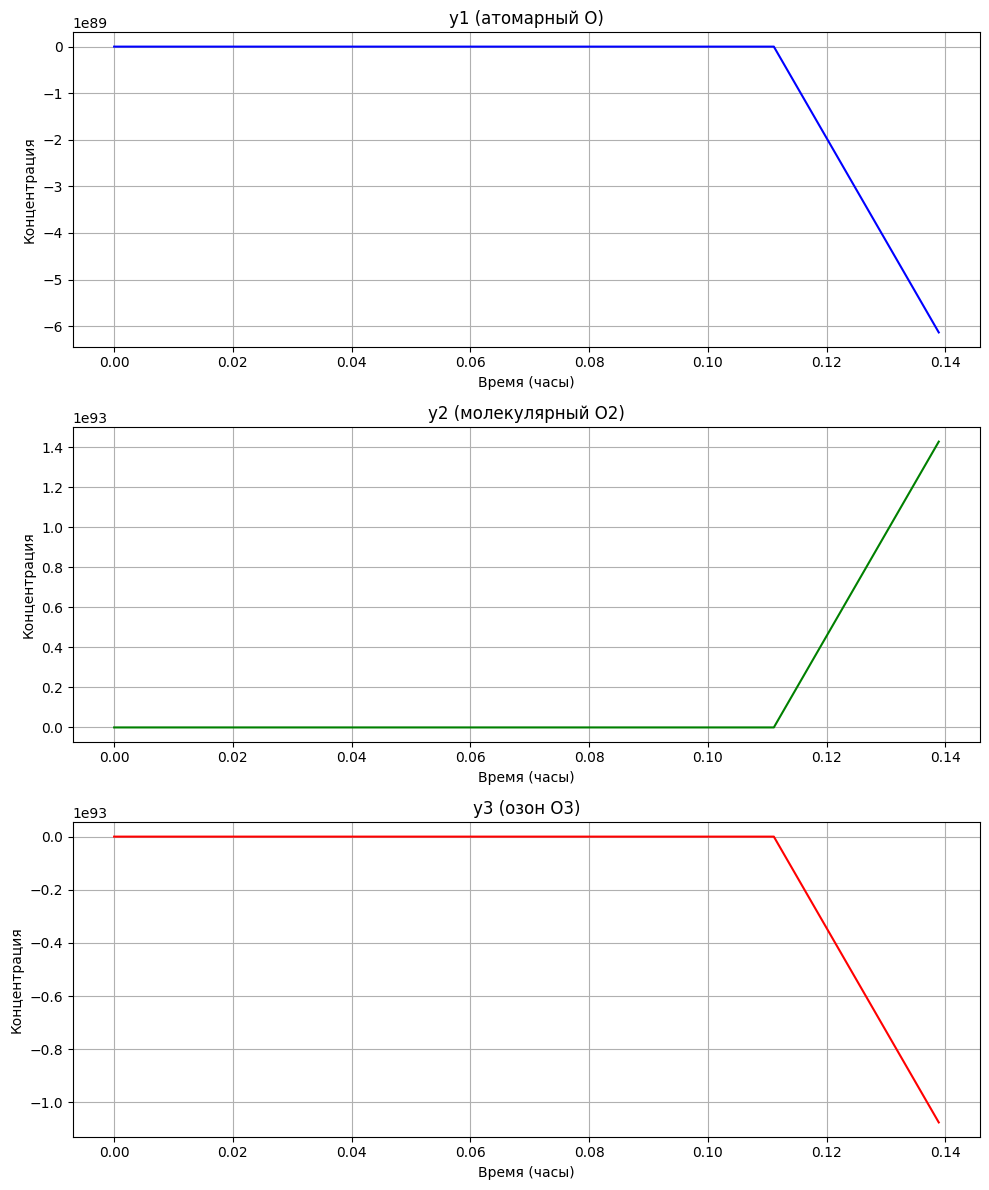

In [24]:
# Таблица Бутчера для ОДНРК
A_rk = np.array([
    [1/4, 0, 0, 0, 0],
    [1/2, 1/4, 0, 0, 0],
    [17/50, -1/25, 1/4, 0, 0],
    [371/1360, -137/2720, 15/544, 1/4, 0],
    [25/24, -49/48, 125/16, -85/12, 1/4]
])
b_rk = np.array([25/24, -49/48, 125/16, -85/12, 1/4])
c_rk = np.array([1/4, 3/4, 11/20, 1/2, 1])

def gauss(A, f):
    A = A.copy()
    f = f.copy()
    n = len(f)

    for k in range(n):
        # Поиск главного элемента
        max_row = np.argmax(np.abs(A[k:, k])) + k
        if abs(A[max_row, k]) < 1e-12:
            raise ValueError("Сингулярная матрица")
        if k != max_row:
            A[[k, max_row]] = A[[max_row, k]]
            f[[k, max_row]] = f[[max_row, k]]

        for i in range(k+1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            f[i] -= factor * f[k]

    # Обратный ход
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (f[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    return x.reshape(-1, 1)

# Метод Ньютона для систем

def newton_system(F_func, J_func, K0, tol=1e-8, max_iter=50):
    K = K0.copy()
    for _ in range(max_iter):
        F_val = F_func(K).reshape(-1, 1)
        J_val = J_func(K)
        try:
            delta = gauss(J_val, F_val)
        except ValueError:
            return K

        K_new = K.flatten() - delta.flatten()
        if np.linalg.norm(K_new - K.flatten()) < tol:
            return K_new.reshape(K.shape)
        K = K_new.reshape(K.shape)
    return K

# Один шаг ОДНРК через метод Ньютона

def irk43_step_newton(t, Y, h, f):
    s = len(b_rk)
    n = len(Y)
    K0 = np.tile(f(t, Y), (s, 1))

    def F(K):
        F_out = np.zeros_like(K)
        for i in range(s):
            Yi = Y + h * np.sum(A_rk[i, j] * K[j] for j in range(s))
            F_out[i] = f(t + c_rk[i] * h, Yi)
        return F_out

    def J(K):
        eps_jac = 1e-8 * max(1.0, np.linalg.norm(K))
        nK = K.shape
        J_mat = np.zeros((nK[0]*nK[1], nK[0]*nK[1]))
        F0 = F(K).reshape(-1)
        for i in range(nK[0]):
            for j in range(nK[1]):
                dK = np.zeros_like(K)
                dK[i, j] = eps_jac
                F1 = F(K + dK).reshape(-1)
                J_mat[:, i*nK[1] + j] = (F1 - F0) / eps_jac
        return J_mat

    K_sol = newton_system(F, J, K0)
    Y_next = Y + h * sum(b_rk[i] * K_sol[i] for i in range(s))
    return Y_next

# Основной интегратор

def solve_irk43_newton(Y0, h, t_end, f):
    t = 0
    ts = [t]
    Ys = [Y0.copy()]
    Y = Y0.copy()

    while t < t_end:
        Y = irk43_step_newton(t, Y, h, f)
        t += h
        ts.append(t)
        Ys.append(Y.copy())

    return np.array(ts), np.array(Ys)

h = 100

# Решение
ts, Ys = solve_irk43_newton(Y0, h, T, f)

# Построение графиков
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(ts/3600, Ys[:, 0], color='blue')
axes[0].set_title("y1 (атомарный O)")
axes[0].set_xlabel("Время (часы)")
axes[0].set_ylabel("Концентрация")
axes[0].grid()

axes[1].plot(ts/3600, Ys[:, 1], color='green')
axes[1].set_title("y2 (молекулярный O2)")
axes[1].set_xlabel("Время (часы)")
axes[1].set_ylabel("Концентрация")
axes[1].grid()

axes[2].plot(ts/3600, Ys[:, 2], color='red')
axes[2].set_title("y3 (озон O3)")
axes[2].set_xlabel("Время (часы)")
axes[2].set_ylabel("Концентрация")
axes[2].grid()

plt.tight_layout()
plt.show()


Я пробовал запускать код с разными шагами интегрирования, но помимо того, что я решаю уравнения для жёсткой системы, начальные условия для них и постоянные скоростей химических реакций разбросаны в огромном диапазоне -  от $10^{-16}$ до $10^{16}$. Видимо из-за этого мой метод Ньютона плохо справляется с решением СНУ и расчёты происходят очень долго даже для шага $h = 100$.
Я пробовал запускать расчёты с шагом $h = 1$ и оставить расчёты на ночь, но это тоже не помогло, значения просто улетают в космос и переменные питона переполняются

Я попробовал скормить своему методу нежёсткую систему из первой лабы, но почему-то даже с ней метод не справился

C:\Users\osale\AppData\Local\Temp\ipykernel_18960\76959490.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Yi = Y + h * np.sum(A_rk[i, j] * K[j] for j in range(s))
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\76959490.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = (f[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]


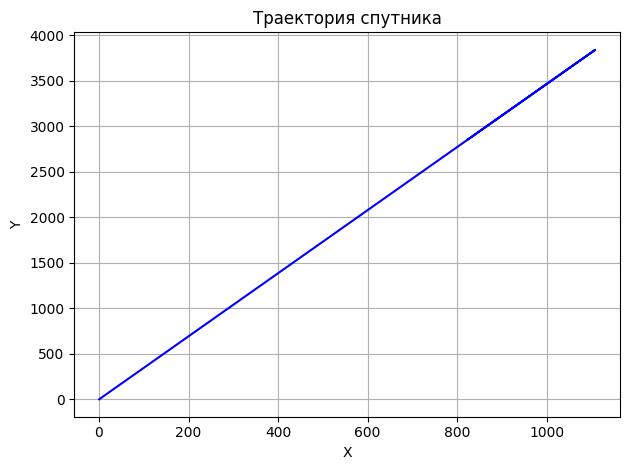

In [27]:
def f(t, Y):
    x, y, z, u = Y
    r3 = (x**2 + y**2)**1.5
    return np.array([z, u, -x / r3, -y / r3])

Y0 = np.array([0.5, 0, 0, np.sqrt(3)])
T = 172800
h = 1
ts, Ys = solve_irk43_newton(Y0, h, T, f)

# Построение графиков
plt.plot(Ys[:, 0], Ys[:, 1], color='blue')
plt.title("Траектория спутника")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.tight_layout()
plt.show()

<h3 style="text-align:center;">Неявный метод Адамса</h3>

**Неявный метод Адамса 3-го порядка:**

$$
y_{n+1} = y_n + h \left( \frac{9}{24} f_{n+1} + \frac{19}{24} f_n - \frac{5}{24} f_{n-1} + \frac{1}{24} f_{n-2} \right)
$$


C:\Users\osale\AppData\Local\Temp\ipykernel_18960\2479441272.py:23: RuntimeWarning: overflow encountered in scalar multiply
  dy1 = -k1 * y1 * y2 - k2 * y1 * y3 + 2 * k3(t) * y2 + k4(t) * y3
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\2479441272.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  dy1 = -k1 * y1 * y2 - k2 * y1 * y3 + 2 * k3(t) * y2 + k4(t) * y3
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\2479441272.py:24: RuntimeWarning: overflow encountered in scalar multiply
  dy2 = 2 * k2 * y1 * y3 - k3(t) * y2
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\2479441272.py:25: RuntimeWarning: overflow encountered in scalar multiply
  dy3 = k1 * y1 * y2 - k2 * y1 * y3 - k4(t) * y3
C:\Users\osale\AppData\Local\Temp\ipykernel_18960\3790008538.py:54: RuntimeWarning: invalid value encountered in subtract
  J[:, i] = (f(t, Y_perturbed) - f0) / eps


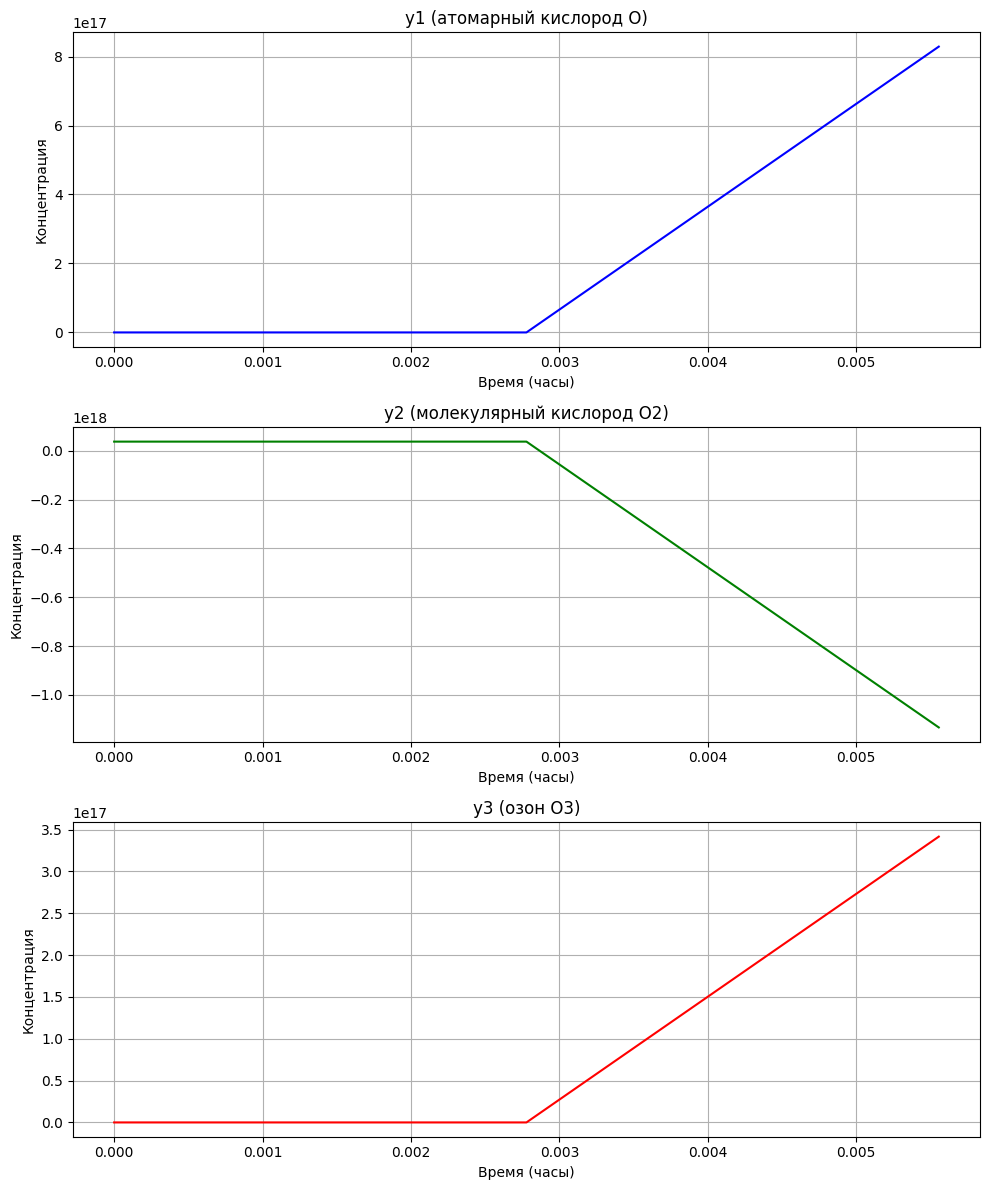

In [ ]:
# Явный шаг Рунге-Кутты 4-го порядка для старта
def rk4_step(t, Y, h, f):
    k1_ = f(t, Y)
    k2_ = f(t + h/2, Y + h/2 * k1_)
    k3_ = f(t + h/2, Y + h/2 * k2_)
    k4_ = f(t + h, Y + h * k3_)
    return Y + h/6 * (k1_ + 2*k2_ + 2*k3_ + k4_)

# Решение системы линейных уравнений методом Гаусса
def gauss(A, f):
    A = A.copy()
    f = f.copy()
    n = len(f)
    for k in range(n):
        max_row = np.argmax(np.abs(A[k:, k])) + k
        if abs(A[max_row, k]) < 1e-12:
            raise ValueError("Сингулярная матрица")
        if k != max_row:
            A[[k, max_row]] = A[[max_row, k]]
            f[[k, max_row]] = f[[max_row, k]]
        for i in range(k+1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            f[i] -= factor * f[k]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (f[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    return x

# Метод Ньютона для поиска Yn+1
def newton_step(tn1, Y_guess, h, Y_prev, f_prev, f_prev1, f_prev2, tol=1e-8, max_iter=20):
    for _ in range(max_iter):
        F_val = Y_guess - Y_prev - h*(9/24 * f(tn1, Y_guess) + 19/24 * f_prev - 5/24 * f_prev1 + 1/24 * f_prev2)

        J = np.eye(len(Y_guess)) - (h * 9/24) * jacobian(tn1, Y_guess)

        delta = gauss(J, F_val)

        Y_guess = Y_guess - delta

        if np.linalg.norm(delta) < tol:
            break

    return Y_guess

# Численный Якобиан
def jacobian(t, Y, eps=1e-8):
    n = len(Y)
    J = np.zeros((n, n))
    f0 = f(t, Y)
    for i in range(n):
        Y_perturbed = Y.copy()
        Y_perturbed[i] += eps
        J[:, i] = (f(t, Y_perturbed) - f0) / eps
    return J

# Основной интегратор

def solve_adams3(Y0, h, t_end):
    t = 0
    ts = [t]
    Ys = [Y0.copy()]
    Y_hist = [Y0.copy()]
    f_hist = [f(t, Y0.copy())]

    # Стартуем методом Рунге-Кутты
    for _ in range(2):
        Y_next = rk4_step(t, Y_hist[-1], h, f)
        t += h
        ts.append(t)
        Ys.append(Y_next.copy())
        Y_hist.append(Y_next.copy())
        f_hist.append(f(t, Y_next))

    while t < t_end:
        t += h
        Y_predict = Y_hist[-1]
        Y_corrected = newton_step(t, Y_predict, h, Y_hist[-1], f_hist[-1], f_hist[-2], f_hist[-3])

        ts.append(t)
        Ys.append(Y_corrected.copy())

        Y_hist.append(Y_corrected.copy())
        f_hist.append(f(t, Y_corrected))

        if len(Y_hist) > 3:
            Y_hist.pop(0)
            f_hist.pop(0)

    return np.array(ts), np.array(Ys)

# Начальные условия
Y0 = np.array([1e6, 3.7e16, 1e12])
h = 10
t_end = 172800  # 2 суток

ts, Ys = solve_adams3(Y0, h, t_end)

# Построение графиков
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
axes[0].plot(ts/3600, Ys[:, 0], color='blue')
axes[0].set_title("y1 (атомарный кислород O)")
axes[0].set_xlabel("Время (часы)")
axes[0].set_ylabel("Концентрация")
axes[0].grid()

axes[1].plot(ts/3600, Ys[:, 1], color='green')
axes[1].set_title("y2 (молекулярный кислород O2)")
axes[1].set_xlabel("Время (часы)")
axes[1].set_ylabel("Концентрация")
axes[1].grid()

axes[2].plot(ts/3600, Ys[:, 2], color='red')
axes[2].set_title("y3 (озон O3)")
axes[2].set_xlabel("Время (часы)")
axes[2].set_ylabel("Концентрация")
axes[2].grid()

plt.tight_layout()
plt.show()


Как видно по графикам, метод Адамса тоже не справляется с моей жёсткой ОДУ, а значения улетают даже раньше, чем в методе Рунге - Кутты

Попробуем протестировать метод хотя бы на нежёсткой системе

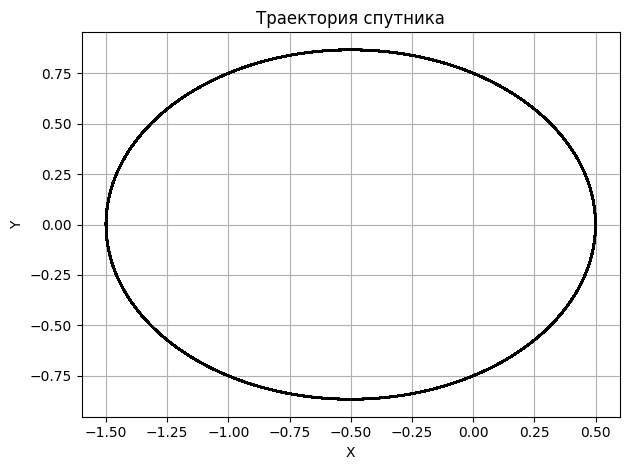

In [15]:
def f(t, Y):
    x, y, z, u = Y
    r3 = (x**2 + y**2)**1.5
    return np.array([z, u, -x / r3, -y / r3])

Y0 = np.array([0.5, 0, 0, np.sqrt(3)])
T = 1000
h = 0.01
ts, Ys = solve_adams3(Y0, h, T)

# Построение графиков
plt.plot(Ys[:, 0], Ys[:, 1], color='black')
plt.title("Траектория спутника")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.tight_layout()
plt.show()

Хоть тут работает)

<h3 style="text-align:center;">Метод Розенброка - Ваннера</h3>

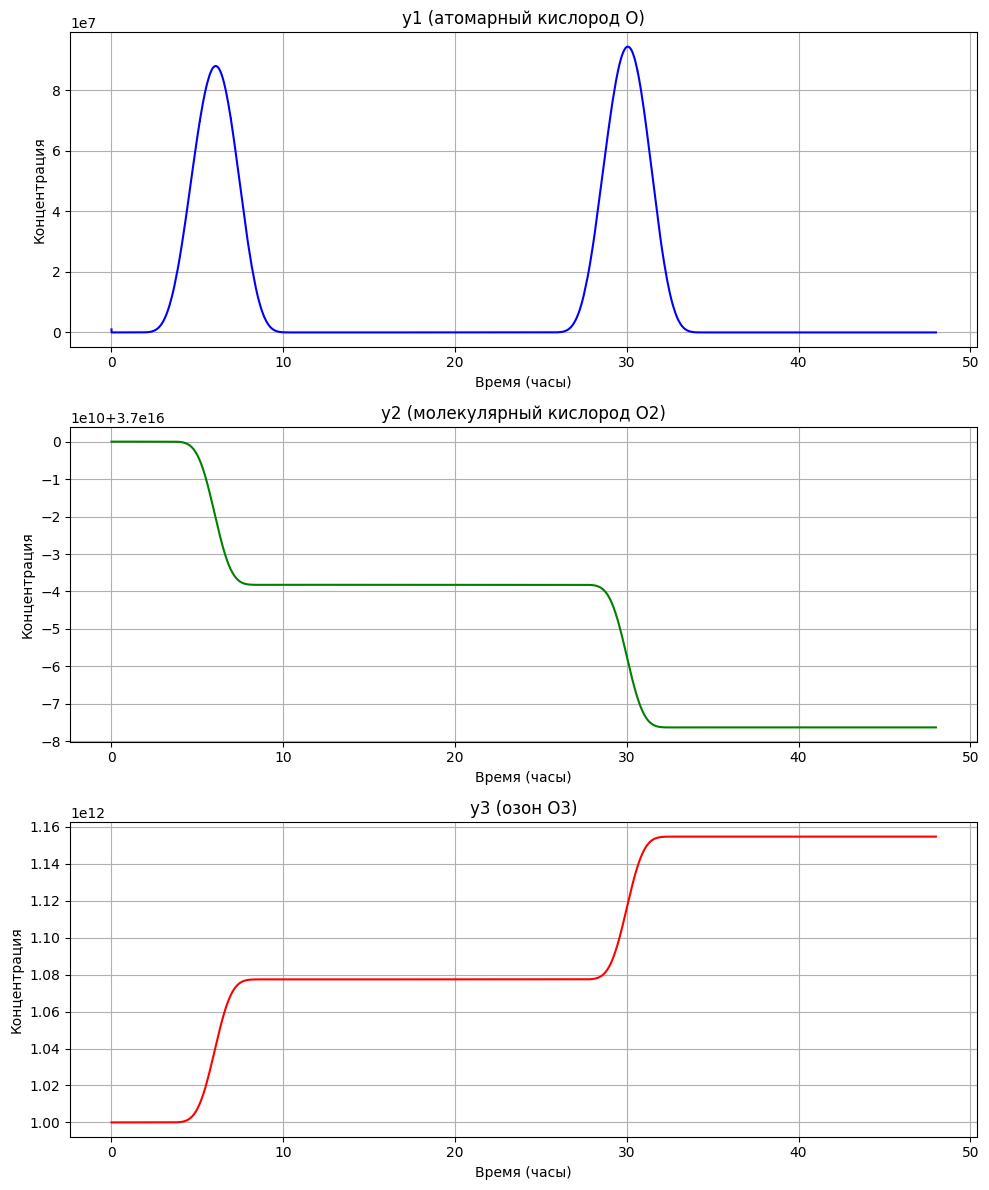

In [ ]:
def f(t, Y):
    y1, y2, y3 = Y
    dy1 = -k1 * y1 * y2 - k2 * y1 * y3 + 2 * k3(t) * y2 + k4(t) * y3
    dy2 = 2 * k2 * y1 * y3 - k3(t) * y2
    dy3 = k1 * y1 * y2 - k2 * y1 * y3 - k4(t) * y3
    return np.array([dy1, dy2, dy3])

def jacobian(f, t, Y, eps=1e-8):
    n = len(Y)
    J = np.zeros((n, n))
    f0 = f(t, Y)
    for i in range(n):
        Y_pert = Y.copy()
        Y_pert[i] += eps
        J[:, i] = (f(t, Y_pert) - f0) / eps
    return J

# Метод Розенброка - Ваннера 3го порядка
def rosenbrock_wanner3_step(t, Y, h, f, gamma=0.5):
    n = len(Y)
    I = np.eye(n)
    J = jacobian(f, t, Y)
    A = I - h * gamma * J

    F1 = f(t, Y)
    K1 = np.linalg.solve(A, F1)

    F2 = f(t + h / 2, Y + h * K1 / 2)
    K2 = np.linalg.solve(A, F2 - gamma * J @ K1)

    F3 = f(t + h, Y - h * K1 + 2 * h * K2)
    K3 = np.linalg.solve(A, F3 - 2 * gamma * J @ K2)

    Y_next = Y + h / 6 * (K1 + 4 * K2 + K3)
    return Y_next

# Интегратор
def solve_rosenbrock_wanner3(Y0, h, t_end):
    t = 0
    ts = [t]
    Ys = [Y0.copy()]
    Y = Y0.copy()
    while t < t_end:
        Y = rosenbrock_wanner3_step(t, Y, h, f)
        if np.any(np.isnan(Y)) or np.any(np.abs(Y) > 1e100):
            break
        t += h
        ts.append(t)
        Ys.append(Y.copy())
    return np.array(ts), np.array(Ys)

Y0 = np.array([1e6, 3.7e16, 1e12])
T = 172800
h = 0.01

ts_rw3, Ys_rw3 = solve_rosenbrock_wanner3(Y0, h, T)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(ts_rw3 / 3600, Ys_rw3[:, 0], color='blue')
axes[0].set_title("y1 (атомарный кислород O)")
axes[0].set_xlabel("Время (часы)")
axes[0].set_ylabel("Концентрация")
axes[0].grid()

axes[1].plot(ts_rw3 / 3600, Ys_rw3[:, 1], color='green')
axes[1].set_title("y2 (молекулярный кислород O2)")
axes[1].set_xlabel("Время (часы)")
axes[1].set_ylabel("Концентрация")
axes[1].grid()

axes[2].plot(ts_rw3 / 3600, Ys_rw3[:, 2], color='red')
axes[2].set_title("y3 (озон O3)")
axes[2].set_xlabel("Время (часы)")
axes[2].set_ylabel("Концентрация")
axes[2].grid()

plt.tight_layout()
plt.show()


Метод Розенброка - Ваннера 3го порядка отлично справляется с решением жёсткой системой ОДУ, по сравнению с предыдущими неявными методами. Данный расчёт с шагом 0.01 длился около получаса

**ВЫВОД:**

Явный метод Рунге - Кутты 4-го порядка сработал на жёсткой системе, потому что я выбрал достаточно мелкий шаг интегрирования. Неявные же методы Рунге - Кутты и Адамса не смогли относительно точно постороить интегральные кривые, потому что они очень долго исполняются, из-за чего я просто не смог дождаться результата при достаточно малых шагах интегрирования (уже при шаге $h = 1$ методы крайне долго работают). \
Метод Розенброка - Ваннера успешно справился с решением жёсткой ОДУ, но тоже при малом шаге

Я не стал добавлять много графиков с разными шагами интегрирования, т.к. во-первых, очень долго мучился, почему неявные методы не срабатывают, а во-вторых, потому что методы занимают много времени для расчёта, поэтому если графики получались верные, то при ещё меньшем шаге они явно останутся теми же, а просто так ждать в 10 раз дольше ради таких же графиков не особо хотелось)